In [1]:
 #!pip install gym[atari,accept-rom-license]

In [2]:
# !apt install xvfb
# !pip install gym-notebook-wrapper
# !pip show tensorflow

In [3]:
# Check that tensor flow is able to use the GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-11-03 09:53:37.119887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2022-11-03 09:53:39.039861: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-03 09:53:39.045567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-03 09:53:39.111766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 09:53:39.112657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.4175GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-11-03 09:53:39.112754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-03 09:53:39.194736: I tensorflow/stream_executor/platform

# Dueling Network Architecture Implementation
The Duelling network is an artificial neural network architecture that has improved the state of the art in the DQN area used in combination with Dual DQN and Prioritized Experience Replay. This approach splits the action value calculation using a combination of state value function and advantage function.

# Searching for available environments
We want to test the performance of our architecture with the Atari game 'Asterix'.
Here we check which kind of versions of this game are available.

In [4]:
from gym import envs

# Searching for available environments
game_name = "Asterix"
all_envs = envs.registry.values()
env_ids = [env_spec.id for env_spec in all_envs]

for id in sorted(env_ids):
    if game_name in id:
        print(id)

ALE/Asterix-ram-v5
ALE/Asterix-v5
Asterix-ram-v0
Asterix-ram-v4
Asterix-ramDeterministic-v0
Asterix-ramDeterministic-v4
Asterix-ramNoFrameskip-v0
Asterix-ramNoFrameskip-v4
Asterix-v0
Asterix-v4
AsterixDeterministic-v0
AsterixDeterministic-v4
AsterixNoFrameskip-v0
AsterixNoFrameskip-v4


# Environment Configuration
We select the version 4 of the environment with no frame skipping and select as render mode human. The no frame skipping is used to make this environment compatible with the optimization made by *AtariPreprocessing*.

In [5]:
import gym
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

# Make Parameters:
game_name = "Asterix"
game_mode = "NoFrameskip"  # [Deterministic | NoFrameskip | ram | ramDeterministic | ramNoFrameskip ]
game_version = "v4"  # [v0 | v4 | v5]
env_name = '{}{}-{}'.format(game_name, game_mode, game_version)
env_render_mode = 'human'  # [human | rgb_array]
env_frame_skip = 4

env = gym.make(env_name, render_mode=env_render_mode)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
/home/ste/anaconda3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/ste/anaconda3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/home/ste/anaconda3/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/ste/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


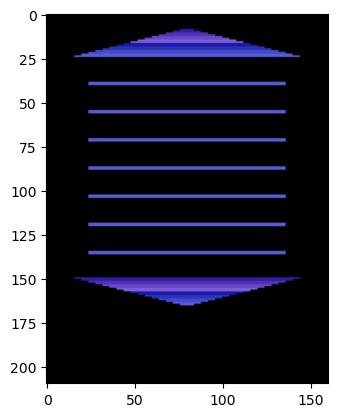

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

env.reset() 
state = env.render(mode="rgb_array")
plt.imshow(state)

## Enviornment Observations
Below we have a first look at the environment characteristics.

In [7]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [8]:
env.action_space

Discrete(9)

In [9]:
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

## Environment Optimization
We optimize the environment by adding the frame skipping, changing its observation in greyscale and following the experiment done in the paper we set to at most 30 the no-op actions; to get this we use the AtariPreprocessing wrapper.
We use Framestack to create observations of 4 frames to give the idea of movement to the agent.

In [10]:
env = AtariPreprocessing(env, frame_skip=env_frame_skip, grayscale_obs=True, terminal_on_life_loss=True, noop_max=30)

/home/ste/anaconda3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/home/ste/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


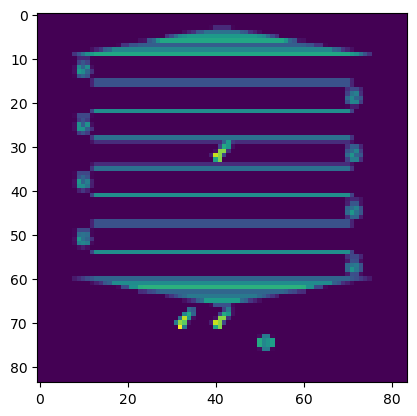

In [11]:
env = FrameStack(env, 4)
state = env.reset()
plt.imshow(state[0])

In [12]:
env.observation_space.shape

(4, 84, 84)

In [13]:
env.action_space

Discrete(9)

# Network configuration

## Policy
The policy is the component that chooses the action to perform; using an $\epsilon$-gready policy the action chosen can be random with probability $\epsilon$ or an action suggested by the ANN with probability $1 - \epsilon$.

In [14]:
from numpy import random
import tensorflow as tf


class EpsilonGreedyPolicy:

    def __init__(self, model, action_space_size, episodes=1, min_epsilon=0, decay_rate=1.35):
        self.model = model
        self.action_space_size = action_space_size
        self.min_epsilon = min_epsilon
        self.episode = 1
        self.episodes = episodes
        self.decay_rate = decay_rate

    def get_action(self, state):
        epsilon_decay = (self.episode / self.episodes)*self.decay_rate
        epsilon = max(1 - epsilon_decay, self.min_epsilon)
        rnd = random.random()
        # print(random, epsilon)
        if rnd < epsilon:
            action = random.randint(self.action_space_size)
            return action
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = self.model(state_tensor)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()
            return action

    def next_episode(self):
        self.episode += 1

    def reset_episodes(self):
        self.episode = 1


## Replication Buffer

### Prioritized experience replay
The Prioritized experience replay was introduced in the paper "Prioritized experience replay" (https://arxiv.org/abs/1511.05952), it consists in an evolution of the replay buffer that orders the experiences to replay by priority. In this experiment we adopt the **rank-based** variant where the experience sampling from the buffer it's done with probability $ P(i) = \frac{p_{i}^{\alpha}}{\sum_k{p_{k}^{\alpha}}} $ and $p(i)=\frac{1}{rank(i)}$ where $rank(i)$ is the rank of the transition *i*, $\alpha$ is called **priority exponent**. It is necessary to compute the importance sampling weights as $w_j = \frac{(N * P(j))^{-\beta}}{max_i{w_i}} $ and $w_i = (\frac{1}{N} . \frac{1}{P(i)})^\beta$ to avoid overfitting for the experiences with more priority.

In both the paper the parameters are setted as follows: **priority exponent** $\alpha= 0.7$,  the **importance sampling exponent** $\beta = [0.5, 1]$.
In the paper a heap array structure is proposed to implement the buffer. Due to the particular structure and the amount of property of the replay buffer in the Prioritized Experience Replay we choose to describe it as a class.

In [15]:
# import heapq as heap
import numpy as np
import scipy.stats as stats
import heapq

from decorator import append


class PrioritizedExperienceReplayRankBased:
    """
    replay_buffer       - contains the tuples (TD_error, transaction_id, experience)
    max_buffer_size     - it's the max size of the buffer, over which before add an experience one is remove
    alpha               - the alpha parameter used to calculate the probability of the i-th element P(i) to be sampled
    self.max_td_error   - max td in the buffer

    Old
    time_to_haepify - time steps before sort the structure
    """

    def __init__(self, max_buffer_size, alpha):
        self.max_buffer_size = max_buffer_size
        # (TD, experience)
        self.replay_buffer = []
        self.alpha = alpha
        # The experience added has the maximum priority but once it sampled it will be updated with a more correct
        # value.
        self.max_td_error = 0
        # self.heapify_threshold = step_to_heapify  # here we stock the threshold to sort the buffer
        # self.step_to_heapify = step_to_heapify  # number of next steps before heapify

    def set_alpha(self, alpha):
        self.alpha = alpha

    # Add experience in the buffer mapping it with its last TD_error.
    # Heapq structure try to sort the elements of different tuple comparing from the first element of the tuple and
    # continuing with next element until the two tuples have an element different. We are interested in sorting by TD,
    # we don't care to sort on states, actions, or rewards. So, we use the transaction id to sort the transaction
    # that is older in the buffer.
    # The transaction_id of a transaction could be the -ith frame number of the whole training representing
    # when the transaction happened.
    # NB This approach avoids headppush fails when try to compare two states.
    def add_experience(self, transaction_id, experience):
        if len(self.replay_buffer) == self.max_buffer_size:
            self.remove_experience()

        # New experiences where td_error is unknown are set with the max td_error
        if len(self.replay_buffer) > 0:
            self.max_td_error = self.replay_buffer[0][0]
        heapq.heappush(self.replay_buffer, (-self.max_td_error, transaction_id, experience))

    # Remove experience from the buffer
    def remove_experience(self, index=-1):
        self.replay_buffer.pop(index)

    @staticmethod
    def zip_f_sampling(alpha, n):
        x = np.arange(1, n + 1)
        weights = x ** (-alpha)
        weights /= weights.sum()
        zipf = stats.rv_discrete(values=(x, weights))
        return zipf.rvs() - 1

    # Get batch_size samples from the buffer; using the beta parameter to compute the importance sampling weight
    # Beta value can change while training we can delegate its control outside
    def sample_experience(self, batch_size, beta):
        experiences = []
        importance_sampling_weights = []
        n = len(self.replay_buffer) - 1
        indexes = []
        transaction_id = []

        for i in range(0, batch_size):
            # Sample index and check the experience is not already present in the batch
            index = self.zip_f_sampling(self.alpha, n)
            while index in indexes:
                index = self.zip_f_sampling(self.alpha, n)
            indexes.append(index)
            # importance sampling weights computation
            rank = index + 1
            pj = 1 / rank
            importance_sampling_weights.append(((n * pj) ** (-beta)))
            transaction_id.append(self.replay_buffer[index][1])
            experiences.append(self.replay_buffer[index][2])

        # Normalization step
        max_weight = max(importance_sampling_weights)
        importance_sampling_weights_normalized = np.divide(importance_sampling_weights, max_weight)
        return indexes, transaction_id, experiences, importance_sampling_weights_normalized

    def update_td_error(self, indexes, td_errors):
        # TODO update tupla e dopo ordina
        for index, td_error in zip(indexes, td_errors):
            my_list = list(self.replay_buffer[index])
            my_list[0] = -abs(td_error)
            self.replay_buffer[index] = tuple(my_list)
        heapq.heapify(self.replay_buffer)


## Network parameters

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as krs

input_shape = env.observation_space.shape
num_actions = env.action_space.n

## Neural Network Creation
The network architecture proposed follows the structure used in *"Dueling Network Architectures for Deep Reinforcement Learning"* https://arxiv.org/abs/1511.06581 composed of 3 convolutional layers and 2 fully connected layers for each stream (advantage, value).
It's possible to create a dueling network using the `DQNAgent` of `rl.agents.dqn` setting `enable_dueling_network=True` in the constructor, but the purpose of this experiment is to show how to develop it manually so it is not used.

The output of the value stream and the output of the advantage stream are merged to obtain the action-value function in the last module of the network using the following formula:
$$ Q(s, a; \theta, \alpha, \beta)^\pi = V(s; \theta, \beta)^\pi + (A(s, a; \theta, \alpha)^\pi - \frac{1}{|A|}\sum_{a'}A(s, a'; \theta, \alpha)^\pi) $$

In [17]:
from tensorflow import math

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend


backend.set_image_data_format('channels_first')
def create_dueling_model(input_shape, number_actions):
    inputs = layers.Input(shape=input_shape)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)

    value_stream_1 = layers.Dense(512)(layer4)
    value_stream_2 = layers.Dense(1)(value_stream_1)  # scalar output size

    advantage_stream_1 = layers.Dense(512)(layer4)
    advantage_stream_2 = layers.Dense(number_actions)(advantage_stream_1)  # output size equal to the actions available

    # Combination of the streams: a Q value for each state
    q_values = value_stream_2 + math.subtract(advantage_stream_2, math.reduce_mean(advantage_stream_2, axis=1,
                                                                                   keepdims=True))
    # Alternative q_value
    # q_value = value_stream_2 + (advantage_stream_2 - backend.max(advantage_stream_2, axis=1, keepdims=True))
    return Model(inputs=[inputs], outputs=[q_values])


# Agent 
Here we define a custom agent to perfom action in the environment using a DoubleDQN training

## Play one step
With this function we want to ask the policy what action must be chosen and perform it on the enironment.

## Gradient 
In our scenario the gradient that is backpropageted to the last convolutional layer must be rescaled by $\frac{1}{\sqrt{2}}$. Furthermore we have to realize by hand the gradient clipping that is not realized by the optimizer since we are using a custom loop.

## Double DQN Training
Double DQN algorithm uses a second network, beyond the network used for the prediction. So in the training process the main network is used to choose an action and another to evaluate it, this permits to mitigate the overfitting present in the classic DQN. 

## DQN Agent code:

In [18]:
import math as mt
import tensorflow as tf
import numpy as np


class DuelDQNAgent:

    # We keep the creation model outside the agent to ensure a fine-grained control on it
    def __init__(self, env, model, policy, model_target=None, optimizer=None, replay_buffer=None):
        self.env = env
        self.model_primary = model
        self.model_target = model_target
        self.policy = policy
        self.optimizer = optimizer
        self.replay_buffer = replay_buffer

    def set_policy(self, policy):
        self.policy = policy

    # Execs one action receiving in input the current state
    def play_one_step(self, state):
        action = self.policy.get_action(state)
        # print("action {}".format(action))
        next_state, reward, done, info = self.env.step(action)
        return action, reward, next_state, done, info

    # Play
    def play(self):
        state = self.env.reset()
        steps = 0
        cumulative_reward = 0
        while True:
            action, reward, next_state, done, info = self.play_one_step(state)
            cumulative_reward += reward
            if done:
                print("DONE number of steps: {} reward:  {}".format(steps, cumulative_reward))
                break
            steps += 1
            state = next_state
        return steps, cumulative_reward

    # Double DQN Training
    #     @tf.function
    @staticmethod
    def gradient_clipping(gradients, clipping_value):
        clipped_gradients = [(tf.clip_by_norm(grad, clipping_value)) for grad in gradients]
        return clipped_gradients

    #     @tf.function
    def weighted_gradient(self, best_on_target_q_values, importance_sampling_weights, states, loss_function, mask):
        with tf.GradientTape() as tape:
            batch_size = len(states)
            tape.watch(importance_sampling_weights)
            best_on_target_q_values = tf.expand_dims(best_on_target_q_values, 1)
            all_q_values = self.model_primary(states)
            q_values = tf.reduce_sum(all_q_values * mask, axis=1)
            q_values = tf.expand_dims(q_values, 1)
            # The target and the predicted values has been expanded following the instruction in:
            # https://www.tensorflow.org/api_docs/python/tf/compat/v1/losses/mean_squared_error
            loss_values = loss_function(y_true=best_on_target_q_values, y_pred=q_values,
                                        sample_weight=importance_sampling_weights)
            loss_value = tf.reduce_sum(loss_values) / batch_size

        grads = tape.gradient(loss_value, self.model_primary.trainable_variables)
        return grads, loss_values.numpy()

    @staticmethod
    def rescale_grad(gradients, rescale_value, index):
        tensor_to_scale = gradients[index]
        rescaled_tensor = tensor_to_scale * rescale_value
        gradients[index] = rescaled_tensor
        return gradients

    # Collects samples of the previous experiences from the replay buffer
    # and use them to improve the weights update of the Neural Network.
    def double_dqn_training_step(self, batch_size, loss_function, discount_factor, clipping_value, beta, step_size=1):
        indexes, transaction_ids, experiences, importance_sampling_weights = self.replay_buffer.sample_experience(
            batch_size, beta)
        states, actions, rewards, next_states, dones = [np.array([experience[field_index] for experience in experiences]
                                                                 ) for field_index in range(5)]

        action_space = self.env.action_space.n
        # Predict using the primary network
        next_q_values = self.model_primary.predict(next_states)
        next_q_values_target = self.model_target.predict(next_states)

        # Select the action that lead us to the higher next Q value
        best_actions = np.argmax(next_q_values, axis=1)
        best_action_mask = tf.one_hot(best_actions, action_space)

        next_q_value_target = tf.reduce_sum(next_q_values_target * best_action_mask, axis=1)
        best_on_target_q_values = (rewards + (1 - dones) * discount_factor * next_q_value_target)
        best_on_target_q_values = best_on_target_q_values * (1-dones) - dones

        mask = tf.one_hot(actions, action_space)
        importance_sampling_weights = tf.convert_to_tensor(importance_sampling_weights, tf.float32)
        weighted_gradient, loss_values = self.weighted_gradient(best_on_target_q_values, importance_sampling_weights,
                                                                states, loss_function, mask)
        self.replay_buffer.update_td_error(indexes, loss_values)

        # We rescale the last convolutional layer to 1/sqrt(2) to balance the double backpropagation
        rescale_value = (1 / mt.sqrt(2))
        # The index of the last sequential layer
        index_gradient_to_rescale = 4
        rescaled_grads = self.rescale_grad(weighted_gradient, rescale_value, index_gradient_to_rescale)

        # Since we are in a custom loop we have to clip the gradient by hand, we can't delegate it to the optimizer
        clipped_gradients = self.gradient_clipping(rescaled_grads, clipping_value)
        # Application gradient descent trough optimizer
        self.optimizer.apply_gradients(zip(clipped_gradients, self.model_primary.trainable_variables))

    # We use the training step just when there is enough samples on the replay buffer
    def double_dqn_training(self, batch_size, loss_function, discount_factor, freq_replacement, training_freq,
                            clipping_value, beta_min, beta_max, max_episodes=600, max_steps=10800):
        rewards_stock = []
        steps_stock = []
        cumulative_steps = 0

        for episode in range(1, max_episodes + 1):
            state = self.env.reset()
            rewards = 0
            steps = 0
            beta = max(beta_min, (beta_max * episode / max_episodes))

            while True:
                action, reward, next_state, done, info = self.play_one_step(state)
                experience = [state, action, reward, next_state, done]
                rewards += reward
                self.replay_buffer.add_experience(cumulative_steps, experience)
                cumulative_steps += 1
                steps += 1

                if len(self.replay_buffer.replay_buffer) > batch_size and (cumulative_steps % training_freq) == 0:
                    self.double_dqn_training_step(batch_size, loss_function, discount_factor, clipping_value, beta)
                if (cumulative_steps % freq_replacement) == 0:
                    self.model_target.set_weights(self.model_primary.get_weights())
                if steps == max_steps:
                    print(
                        "ABORTED episode = {} number of steps = {} reward = {}".format(episode, steps, rewards))
                if done:
                    print(
                        "DONE episode = {} number of steps = {} reward = {}".format(episode, steps, rewards))
                if done or steps == max_steps:
                    rewards_stock.append(rewards)
                    steps_stock.append(steps)
                    break
                state = next_state

            self.policy.next_episode()

        return steps_stock, rewards_stock


## Result plots
We use this function to generate the plot representing the rewards or the steps for each episode

In [19]:
def plot_result(x_label, y_label, x, y, name):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y)
    plt.savefig(name)
    plt.show()
    plt.close()

# Training
The learning step is executed with the **Double Deep Q-networks** algorithm presented in the paper *"Deep reinforcement learning with double Q-learning"*.https://arxiv.org/pdf/1509.06461.pdf.

## Training parameters
We adopt as optimizer the **Adam** implementation setting the learning rate equal to $6.25x10^{-5}$ and **clipping the gradient** norm at most to 10; the parameters are specified in the paper "*Deep reinforcement learning with double Q-learning*" (https://arxiv.org/pdf/1509.06461.pdf)
To evaluate the loss score we use the `mean_squared_error`. 

In [20]:
# Network Parameters
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model


# Environment info
input_shape = env.observation_space.shape
actions_number = env.action_space.n

# Model persistent file
primary_model_file_name = "{}_dueling_model".format(game_name)

# Training Parameters
loss_function = losses.MeanSquaredError(reduction=losses.Reduction.NONE)
batch_size = 32 # @param {type:"integer"}
discount_factor = 0.95 # @param {type:"number"}
learning_rate = 6.25e-5 # @param {type:"number"}
episodes = 3000 # @param {type:"integer"}
clipping_value = 10 # @param {type:"number"}
training_freq = 4 # @param {type:"integer"}

# Dual DQN Training
freq_replacement = 1000 # @param {type:"integer"}

# Replay buffer parameters
buffer_size = 100000 # @param {type:"integer"}
# step_to_heapify = 200 # @param {type:"integer"}
alpha = 0.7 # @param {type:"number"}
beta_max = 1 # @param {type:"number"}
beta_min = 0.5 # @param {type:"number"}

# Policy parameters
min_epsilon = 0.01 # @param {type:"number"}


## Model creation / loading 
In this step we check whether there is an already saved model and load it in that case

In [21]:
from pathlib import Path
import pandas as pd

# Model creation
file_primary = Path(primary_model_file_name)
if file_primary.exists():
    print("Found an existing model")
    model = load_model(primary_model_file_name)
else:
    print("Model not found, a new one will be crate")
    model = create_dueling_model(input_shape, actions_number)

# Print a summary about the model
print(model.summary())

Found an existing model


2022-11-03 09:53:41.546098: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 09:53:41.547055: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-03 09:53:41.547230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 09:53:41.547474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.4175GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 84, 84)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 20, 20)   8224        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 9, 9)     32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 7, 7)     36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

## Training
Here we ran the training operation. After a training session we save two plot episodes - rewards, episodes - steps. Also we save a csv with two columns: steps and rewards.

In [22]:
def training():
    try:
        model_target = create_dueling_model(input_shape, actions_number)
        model_target.set_weights(model.get_weights())
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        policy_training = EpsilonGreedyPolicy(model, actions_number, episodes=episodes, min_epsilon=min_epsilon)
        replay_buffer = PrioritizedExperienceReplayRankBased(buffer_size, alpha)
        agent = DuelDQNAgent(env, model, policy_training, model_target, optimizer, replay_buffer)
        steps, rewards = agent.double_dqn_training(batch_size, loss_function, discount_factor, freq_replacement,
                                                   training_freq, clipping_value, beta_min, beta_max, episodes)

        ext = "png"
        name_plot_eps_steps = "{} Training Episodes Steps.{}".format(game_name, ext)
        name_plot_eps_rewards = "{} Training Episodes Rewards.{}".format(game_name, ext)
        file_plot_1 = Path(name_plot_eps_steps)
        i = 1
        while file_plot_1.exists():
            i += 1
            name_plot_eps_steps = "{} Training Episodes Steps_{}.{}".format(game_name, i, ext)
            name_plot_eps_rewards = "{} Training Episodes Rewards_{}.{}".format(game_name, i, ext)
            file_plot_1 = Path(name_plot_eps_steps)

        plot_result("Episode", "Steps", range(1, episodes + 1), steps, name_plot_eps_steps)
        plot_result("Episode", "Rewards", range(1, episodes + 1), rewards, name_plot_eps_rewards)

        csv_name = "{}.csv".format(game_name)
        dict = {'steps': steps, 'rewards': rewards}
        df = pd.DataFrame(dict)
        df.to_csv(csv_name, mode='a', header=False)

    finally:
        model.save(primary_model_file_name)


# Play
Here we play a game (one episode)

In [23]:
def play():
    policy_play = EpsilonGreedyPolicy(model, actions_number, min_epsilon=min_epsilon)
    env
    agent = DuelDQNAgent(env, model, policy_play)
    steps, reward = agent.play()

# Run

In [24]:
let_training = True # @param {type:"boolean"}
let_play = False # @param {type:"boolean"}

2022-11-03 09:53:46.174527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-03 09:53:46.196597: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200660000 Hz
2022-11-03 09:53:46.291364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-03 09:53:46.629241: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


DONE episode = 1 number of steps = 66 reward = 50.0
DONE episode = 2 number of steps = 74 reward = 50.0
DONE episode = 3 number of steps = 119 reward = 250.0
DONE episode = 4 number of steps = 73 reward = 100.0
DONE episode = 5 number of steps = 80 reward = 100.0
DONE episode = 6 number of steps = 105 reward = 200.0
DONE episode = 7 number of steps = 160 reward = 200.0
DONE episode = 8 number of steps = 79 reward = 150.0
DONE episode = 9 number of steps = 74 reward = 200.0
DONE episode = 10 number of steps = 83 reward = 100.0
DONE episode = 11 number of steps = 153 reward = 200.0
DONE episode = 12 number of steps = 85 reward = 100.0
DONE episode = 13 number of steps = 71 reward = 100.0
DONE episode = 14 number of steps = 75 reward = 100.0
DONE episode = 15 number of steps = 79 reward = 50.0
DONE episode = 16 number of steps = 186 reward = 400.0
DONE episode = 17 number of steps = 112 reward = 100.0
DONE episode = 18 number of steps = 81 reward = 100.0
DONE episode = 19 number of steps 

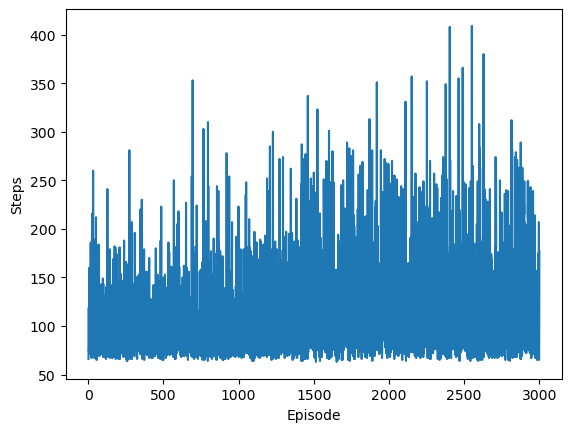

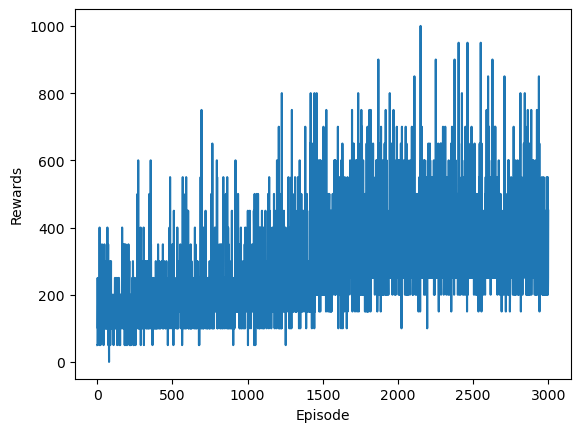

2022-11-03 21:14:44.491069: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Asterix_dueling_model/assets


In [25]:

if let_training:
    training()


In [26]:
if let_play:
    play()

env.close()

In [27]:
#!rm -r ./sample_data

In [28]:
#!zip -r /content/Asterix_dueling.zip /content

In [29]:
#from google.colab import files
#files.download('Asterix_dueling.zip')